In [1]:
# Code from   https://github.com/Skuldur/Classical-Piano-Composer 
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Activation
from keras.layers import GRU
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [1]:
# Mount drive to easily share saved models with the rest of the team
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def get_notes():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []

    for file in glob.glob("<_PATH_>/*.midi"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [4]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM/GRU layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)
    network_output = np_utils.to_categorical(network_output)
    return (network_input, network_output)

In [5]:
def create_network(network_input, n_vocab):
  """ create the structure of the neural network """
  model = Sequential()
  model.add(Bidirectional(GRU(256,
      input_shape=(network_input.shape[1], network_input.shape[2]), #n_time_steps, n_features?
      return_sequences=True)))
  model.add(Dropout(0.1))

  model.add(GRU(256,return_sequences=True))
  model.add(Dropout(0.1))

  model.add(Flatten())
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  
  return model

267454
(267454, 611)
Epoch 1/5
1605/1605 [==============================] - 246s 148ms/step - loss: 4.6658 - val_loss: 4.7456
Epoch 2/5
1605/1605 [==============================] - 235s 147ms/step - loss: 4.5982 - val_loss: 4.7672
Epoch 3/5
1605/1605 [==============================] - 235s 147ms/step - loss: 4.5426 - val_loss: 4.8165
Epoch 4/5
1605/1605 [==============================] - 235s 146ms/step - loss: 4.4835 - val_loss: 4.8083
Epoch 5/5
1605/1605 [==============================] - 235s 146ms/step - loss: 4.4075 - val_loss: 4.8717
dict_keys(['loss', 'val_loss'])


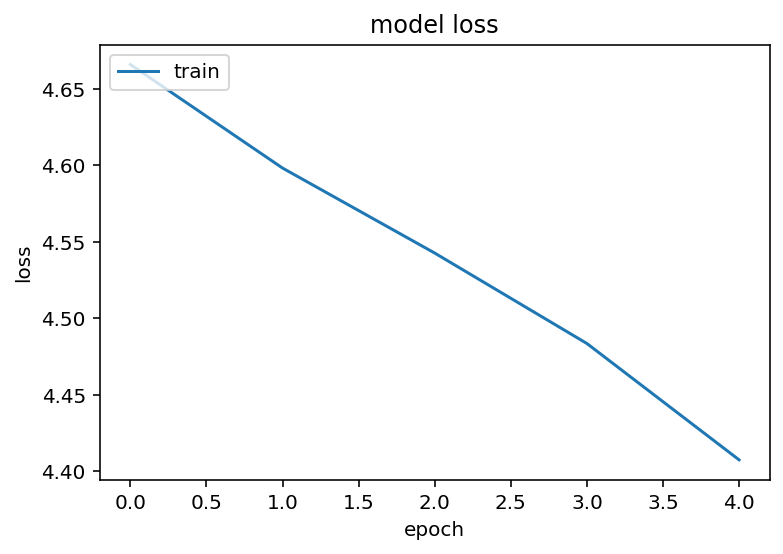

In [9]:
""" This module prepares midi file data and feeds it to the neural
    network for training """

# create the notes file

def train_network():
    """ Train a Neural Network to generate music """
    #notes = get_notes()

    # open a file, where you stored the pickled data
    file = open('<__PICKLED_DATA_FILEPATH__>', 'rb')

    # dump information to that file
    notes = pickle.load(file)

    # get amount of pitch names
    n_vocab = len(set(notes))

    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)

    history = train(model, network_input, network_output)
    return (network_input, network_output, history)


def train(model, network_input, network_output):
    """ train the neural network """
    loss_filepath = "<__MODEL_FILEPATH__>/loss-{epoch:02d}-{loss:.4f}.hdf5"
    checkpoint = ModelCheckpoint(
        loss_filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )

    val_loss_filepath = "<__MODEL_FILEPATH__>/val_loss_{epoch:02d}-{val_loss:.4f}.hdf5"
    val_loss_checkpoint = ModelCheckpoint(
        val_loss_filepath,
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint, val_loss_checkpoint]
    history = model.fit(network_input, network_output, epochs=5, batch_size=150, callbacks=callbacks_list, validation_split=0.1)
    return history

(network_input, network_output, history) = train_network()

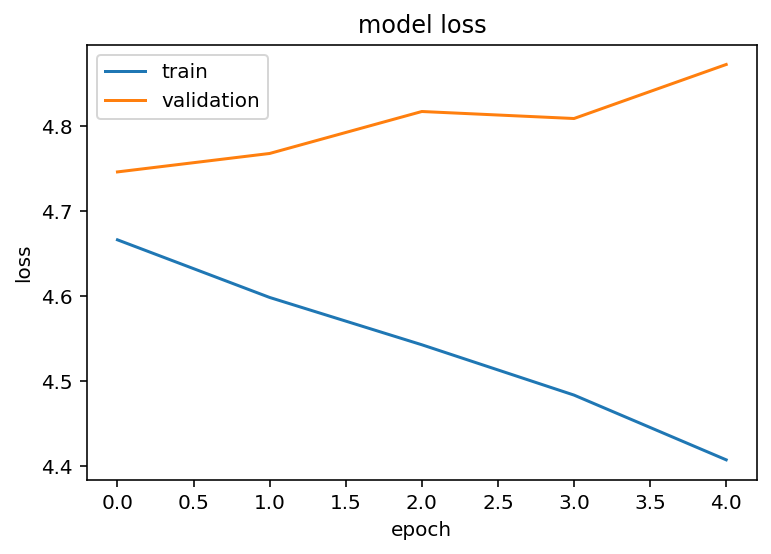

In [11]:
# Plot (validation) loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
""" This module generates notes for a midi file using the
    trained neural network """
import pickle
import numpy
from music21 import instrument, note, stream, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import Activation

def generate():
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('<__DATASET__>', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))
    network_input, normalized_input = prepare_sequences(notes, pitchnames, n_vocab)
    model = create_network(normalized_input, n_vocab)
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

def prepare_sequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)
    print(len(network_input))
    print(len(normalized_input))

    return (network_input, normalized_input)

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    from keras.models import load_model
    model = load_model('<__SAVED_MODEL_FILEPATH__>/weights-improvement-NEW-FINAL1-05-0.4011.hdf5')

    return model

def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(200):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='<__MIDI_FILENAME__>')

if __name__ == '__main__':
    generate()

267454
267454
